# Melanoma data analysis using p3time

The original count data is available at Gene Expression Omnibus: [GSE72056](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE72056).

## Decompress the compressed data files

May be ignored if already done so. 
Either way, you should have a named file `GSE72056_melanoma_single_cell_revised_v2.txt`.

In [1]:
!gzip -d GSE72056_melanoma_single_cell_revised_v2.txt.gz

## Import necessary packages

In [2]:
import p3time

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn import preprocessing

## Read data

In [4]:
GSE72056 = pd.read_csv('./GSE72056_melanoma_single_cell_revised_v2.txt', sep='\t', index_col=0).T
expression_matrix = GSE72056.iloc[:, 3:]
cell_metadata = GSE72056.iloc[:, :3]

In [5]:
meladata = pd.DataFrame(preprocessing.scale(np.log2(expression_matrix + 1)), \
                        index = expression_matrix.index, columns=expression_matrix.columns)

In [6]:
X = torch.tensor(np.array(meladata))
n, p = X.shape

We require cells to be rows.

## Set up the model and fit the model

Here we create a p3time object.
First, we assign the parameter `size`, which denotes the number of genes. 

In [7]:
p3 = p3time.p3time(size = p, steps = 500, n_term = 1, lambdap = 1e-6, lambdae = 1e-5, lambdad = 1e-6, device = "cuda", verbose=100)

In [8]:
p3.fit(X)

Iter 0. Loss 0.7320927381515503
Iter 100. Loss 1.1105377674102783
Iter 200. Loss 1.8219441175460815
Iter 300. Loss 0.9889146685600281
Iter 400. Loss 0.7970786690711975


## Predict pseudotime

In [9]:
pseudotime = p3.predict_pseudotime(X)

## Illustration

Text(0.5, 0, 'pseudotime')

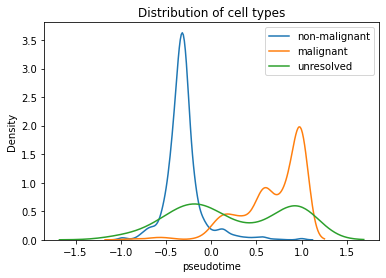

In [10]:
label = {0:"unresolved", 1:"non-malignant",2:"malignant"}

fig, ax = plt.subplots()
plt.title(f"Distribution of cell types")
for i in cell_metadata['malignant(1=no,2=yes,0=unresolved)'].unique():
    sns.kdeplot(
        pseudotime[cell_metadata['malignant(1=no,2=yes,0=unresolved)'] == int(i)], label='%s'%label[i]
    )
plt.legend()
ax.set_xlabel('pseudotime')

## Save a model

In [11]:
p3.save_model('p3time_melanoma.pt')

## Load a trained model

In [12]:
p3.load_model('./trained_mdoel/melanoma.pt')